<a href="https://colab.research.google.com/github/zahra-sharifzadeh/Master_thesis/blob/main/RAVDESS/melspectrogram/mel_spectrograms_parallel_AE_cnn_attention_lstm_Ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy RAVDESS dataset from gdrive and unzip
!cp '/content/drive/MyDrive/RAVDESS.zip' .
!unzip -q RAVDESS.zip

# Load file names

In [ ]:
import torch

In [ ]:
SAMPLE_RATE = 48000

In [ ]:

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 0:'surprise'} # surprise je promenjen sa 8 na 0
DATA_PATH = '/content/audio_speech_actors_01-24'


data = pd.DataFrame(columns=['Emotion', 'Emotion intensity', 'Gender','Path'])
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        file_path = os.path.join('/content/drive/MyDrive/',dirname, filename)
        identifiers = filename.split('.')[0].split('-')
        emotion = (int(identifiers[2]))
        if emotion == 8: # promeni surprise sa 8 na 0
            emotion = 0
        if int(identifiers[3]) == 1:
            emotion_intensity = 'normal'
        else:
            emotion_intensity = 'strong'
        if int(identifiers[6])%2 == 0:
            gender = 'female'
        else:
            gender = 'male'

        data = data._append({"Emotion": emotion,
                            "Emotion intensity": emotion_intensity,
                            "Gender": gender,
                            "Path": file_path
                             },
                             ignore_index = True
                          )


In [ ]:
print("number of files is {}".format(len(data)))
data.head()

number of files is 1440


,Emotion,Emotion intensity,Gender,Path
0,2,strong,female,/content/audio_speech_actors_01-24/Actor_06/03...
1,1,normal,female,/content/audio_speech_actors_01-24/Actor_06/03...
2,7,normal,female,/content/audio_speech_actors_01-24/Actor_06/03...
3,2,normal,female,/content/audio_speech_actors_01-24/Actor_06/03...
4,3,normal,female,/content/audio_speech_actors_01-24/Actor_06/03...


Number of examples per emotion

Text(0, 0.5, 'Number of examples')

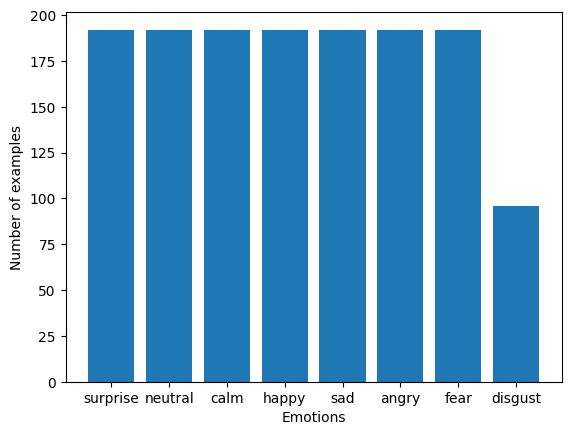

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(8), height=data['Emotion'].value_counts())
ax.set_xticks(ticks=range(8))
ax.set_xticklabels([EMOTIONS[i] for i in range(8)],fontsize=10)
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')

number of examples per gender

Text(0, 0.5, 'Number of examples')

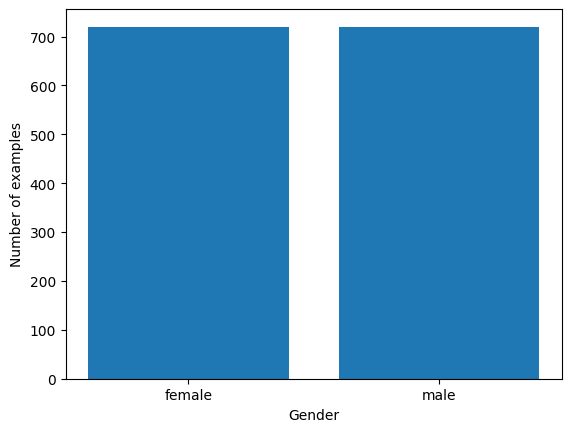

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Gender'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

number of examples per emotion intensity

Text(0, 0.5, 'Number of examples')

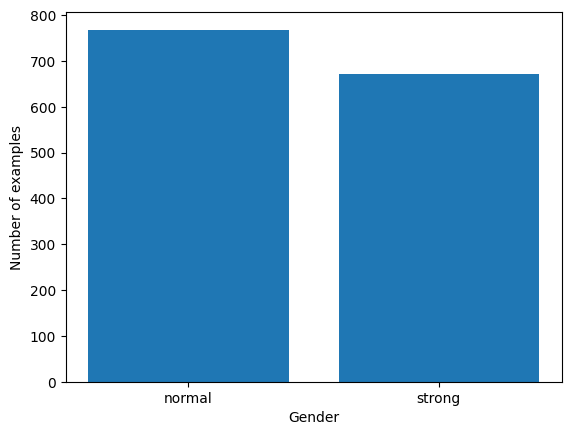

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
counts = data['Emotion intensity'].value_counts()
ax.bar(x=[0,1], height=counts.values)
ax.set_xticks(ticks=[0,1])
ax.set_xticklabels(list(counts.index))
ax.set_xlabel('Gender')
ax.set_ylabel('Number of examples')

# Load the signals

In [ ]:
mel_spectrograms = []
signals = []
for i, file_path in enumerate(data.Path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE*3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\r Processed {}/{} files".format(i,len(data)),end='')
signals = np.stack(signals,axis=0)

 Processed 1439/1440 files

# Split the data

In [ ]:
X = signals
train_ind,test_ind,val_ind = [],[],[]
X_train,X_val,X_test = [],[],[]
Y_train,Y_val,Y_test = [],[],[]
for emotion in range(len(EMOTIONS)):
    emotion_ind = list(data.loc[data.Emotion==emotion,'Emotion'].index)
    emotion_ind = np.random.permutation(emotion_ind)
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8*m)]
    ind_val = emotion_ind[int(0.8*m):int(0.9*m)]
    ind_test = emotion_ind[int(0.9*m):]
    X_train.append(X[ind_train,:])
    Y_train.append(np.array([emotion]*len(ind_train),dtype=np.int32))
    X_val.append(X[ind_val,:])
    Y_val.append(np.array([emotion]*len(ind_val),dtype=np.int32))
    X_test.append(X[ind_test,:])
    Y_test.append(np.array([emotion]*len(ind_test),dtype=np.int32))
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)
X_train = np.concatenate(X_train,0)
X_val = np.concatenate(X_val,0)
X_test = np.concatenate(X_test,0)
Y_train = np.concatenate(Y_train,0)
Y_val = np.concatenate(Y_val,0)
Y_test = np.concatenate(Y_test,0)
train_ind = np.concatenate(train_ind,0)
val_ind = np.concatenate(val_ind,0)
test_ind = np.concatenate(test_ind,0)
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')
# check if all are unique
unique, count = np.unique(np.concatenate([train_ind,test_ind,val_ind],0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count==1), X.shape[0]))

del X

X_train:(1147, 144000), Y_train:(1147,)
X_val:(143, 144000), Y_val:(143,)
X_test:(150, 144000), Y_test:(150,)
Number of unique indexes is 1440, out of 1440


# Augment signals by adding AWGN

In [ ]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30):
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K
    # Generate noisy signal
    return signal + K.T * noise

In [ ]:
aug_signals = []
aug_labels = []
for i in range(X_train.shape[0]):
    signal = X_train[i,:]
    augmented_signals = addAWGN(signal)
    for j in range(augmented_signals.shape[0]):
        aug_labels.append(data.loc[i,"Emotion"])
        aug_signals.append(augmented_signals[j,:])
        # data = data.append(data.iloc[i], ignore_index=True)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
aug_signals = np.stack(aug_signals,axis=0)
X_train = np.concatenate([X_train,aug_signals],axis=0)
aug_labels = np.stack(aug_labels,axis=0)
Y_train = np.concatenate([Y_train,aug_labels])
print('')
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')

 Processed 1146/1147 files
X_train:(3441, 144000), Y_train:(3441,)


# Calculate mel spectrograms

MEL spectrogram shape:  (128, 563)


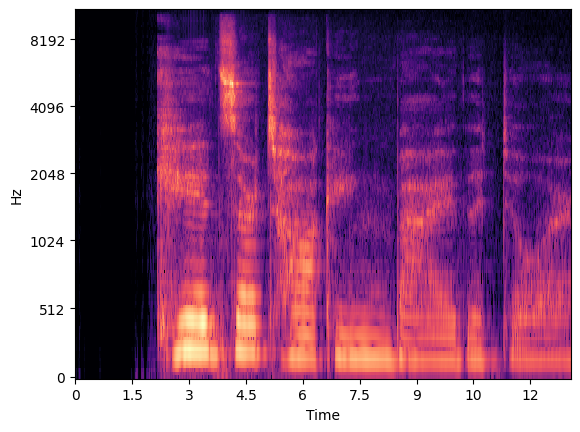

In [ ]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [ ]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)
del X_train
X_train = mel_train

Calculatin mel spectrograms for train set
 Processed 3440/3441 files


In [ ]:
mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val


Calculatin mel spectrograms for val set
 Processed 142/143 files


In [ ]:
mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

Calculatin mel spectrograms for test set
 Processed 149/150 files


In [ ]:
print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

X_train:(3441, 128, 563), Y_train:(3441,)
X_val:(143, 128, 563), Y_val:(143,)
X_test:(150, 128, 563), Y_test:(150,)


# Create the model

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
          #input_shape = [batches, 1, 128, 563] -> output_ conv block1 = [batches, 16, 128, 563]
          # ...->  output_ conv block2 = [batches, 32, 16, 70] ->  output_ conv block3 = [batches , 64, 4, 17]
          #...->  output_ conv block4 = [batches, 64, 1, 4]

        self.encoder = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.SELU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )

    def forward(self, x):
        return self.encoder(x)


In [ ]:
import torch.nn as nn
          #input_shape = [batches, 1, 128, 563] -> output_ conv block1 = [batches, 16, 128, 563]
          # ...->  output_ conv block2 = [batches, 32, 16, 70] ->  output_ conv block3 = [batches , 64, 4, 17]
          #...->  output_ conv block4 = [batches, 64, 1, 4]

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            # Transposed convolution layer
            nn.ConvTranspose2d(64, 64, kernel_size=(1, 5), stride=(1, 4)),
            nn.BatchNorm2d(64),
            nn.SELU(),

            nn.ConvTranspose2d(64, 32, kernel_size=(16, 6), stride=(1, 4)),
            nn.BatchNorm2d(32),
            nn.SELU(),

            nn.ConvTranspose2d(32, 16, kernel_size=(8,11), stride=(8,8)),
            nn.BatchNorm2d(16),
            nn.SELU(),
            nn.ConvTranspose2d(16, 1, kernel_size=(1,1), stride=(1,1)),

        )

    def forward(self, x):
        return self.decoder(x)

decoder = Decoder()
input_data = torch.randn(1, 64, 1, 4)  # Replace with your input shape
decoded = decoder(input_data)
input_data.shape , decoded.shape

(torch.Size([1, 64, 1, 4]), torch.Size([1, 1, 128, 563]))

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Define the encoder and decoder
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)

        # Decode the encoded representation
        decoded = self.decoder(encoded)

        return encoded, decoded


autoencoder = Autoencoder()
input_data = torch.randn(1, 1, 128, 563)  # Replace with your input shape
encoded, decoded = autoencoder(input_data)
encoded.shape, decoded.shape


(torch.Size([1, 64, 1, 4]), torch.Size([1, 1, 128, 563]))

In [ ]:
class LSTM_Feature_Extractor(nn.Module):
    def __init__(self,hidden_size=128):
        super(LSTM_Feature_Extractor, self).__init__()
         # LSTM block
        # self.hidden_size = hidden_size
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM



    def forward(self, x):
             # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)

        return attention, attention_weights_norm

In [ ]:
class Classifier(nn.Module):
  def __init__(self, num_emotions, hidden_size):
    super().__init__()

    self.out_linear = nn.Linear(2*hidden_size+2*256,num_emotions)
    self.dropout_linear = nn.Dropout(p=0)
    self.out_softmax = nn.Softmax(dim=1)

  def forward(self, x):

    output_logits = self.out_linear(x)
    output_logits = self.dropout_linear(output_logits)
    output_softmax = self.out_softmax(output_logits)

    return output_logits, output_softmax




In [ ]:
import torch
import torch.nn as nn

class AE_CNN_LSTM_Model(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()

        hidden_size = 128
        self.autoencoder1 = Autoencoder()
        self.autoencoder2 = Autoencoder()

        self.lstm_block = LSTM_Feature_Extractor(hidden_size = hidden_size)
        self.classifier = Classifier(num_emotions, hidden_size)

    def forward(self,x):
        # conv embedding
        encoded1, decoded1 = self.autoencoder1(x) #(b,channel,freq,time) , input shape
        encoded2, decoded2 = self.autoencoder2(x) #(b,channel,freq,time) , input shape


        encoded_embedding1 = torch.flatten(encoded1, start_dim=1) # do not flatten batch dimension
        encoded_embedding2 = torch.flatten(encoded2, start_dim=1) # do not flatten batch dimension


        # lstm embedding

        attention, attention_weights_norm = self.lstm_block(x)

        # concatenate
        complete_embedding = torch.cat([encoded_embedding1, encoded_embedding2, attention], dim=1)
        output_logits, output_softmax = self.classifier(complete_embedding)


        return output_logits, output_softmax, attention_weights_norm, decoded1,decoded2, encoded1, encoded2


In [ ]:
# def loss_fnc(predictions, targets):
#     return nn.CrossEntropyLoss()(input=predictions,target=targets)

loss_fnc_classification = nn.CrossEntropyLoss()
AE_loss_fnc = nn.MSELoss()

# TRAINING

In [ ]:
def make_train_step(model, loss_fnc_classification, AE_loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm, decoded1,decoded2, encoded1, encoded2 = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        LC = loss_fnc_classification(output_logits, Y)
        LA1 = AE_loss_fnc(decoded1, X)
        LA2 = AE_loss_fnc(decoded2, X)

        TH = 0.3
        loss = TH * (LA1 + LA2) + (1-TH) * (LC)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100, LC.item(), LA1.item(),LA2.item(),  decoded1,decoded2, encoded1, encoded2
    return train_step

In [ ]:
def make_validate_fnc(model,loss_fnc_classification, AE_loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm, decoded1,decoded2, encoded1, encoded2  = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            LC = loss_fnc_classification(output_logits, Y)
            LA1 = AE_loss_fnc(decoded1, X)
            LA2 = AE_loss_fnc(decoded2, X)

            TH = 0.3
            loss = TH * (LA1 + LA2) + (1-TH) * (LC)
        return loss.item(), accuracy*100, predictions, LC.item(), LA1.item(),LA2.item(),  decoded1,decoded2, encoded1, encoded2
    return validate

scale data

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = np.expand_dims(X_train,1)
X_val = np.expand_dims(X_val,1)
X_test = np.expand_dims(X_test,1)

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

In [ ]:
X_train.shape

(3441, 1, 128, 563)

In [ ]:
X_train.min(), X_train.max()

(-5.6735353276484854, 5.284298179001441)

Train the model

In [ ]:
EPOCHS=500
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))

Selected device is cuda


In [ ]:
model = AE_CNN_LSTM_Model(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

Number of trainable params:  851211


In [ ]:
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [ ]:

train_step = make_train_step(model, loss_fnc_classification, AE_loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc_classification, AE_loss_fnc)

#####
losses = []
LA1s = []
LA2s = []
LCs = []

val_losses = []
val_LA1s = []
val_LA2s = []
val_LCs = []
#####

for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)

    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]

    epoch_acc = 0
    epoch_loss = 0
    epoch_LA1 = 0
    epoch_LA2 = 0
    epoch_LC = 0

    iters = int(DATASET_SIZE / BATCH_SIZE)

    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)

        loss, acc, LC, LA1, LA2, decoded1,decoded2, encoded1, encoded2 = train_step(X_tensor,Y_tensor)

        epoch_acc += acc*actual_batch_size/DATASET_SIZE

        epoch_loss += loss * actual_batch_size/DATASET_SIZE
        epoch_LA1   += LA1 * actual_batch_size/DATASET_SIZE
        epoch_LA2   += LA2 * actual_batch_size/DATASET_SIZE
        epoch_LC   += LC * actual_batch_size/DATASET_SIZE

        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)


    val_loss, val_acc, predictions, val_LC, val_LA1, val_LA2, val_decoded1, val_decoded2, val_encode1, val_encode2 = validate(X_val_tensor,Y_val_tensor)


    losses.append(epoch_loss)
    LA1s.append(epoch_LA1)
    LA2s.append(epoch_LA2)
    LCs.append(epoch_LC)


    val_losses.append(val_loss)
    val_LA1s.append(val_LA1)
    val_LA2s.append(val_LA2)
    val_LCs.append(val_LC)


    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    print(f"Epoch {epoch} --> epoch_LA1:{epoch_LA1:.4f},epoch_LA2:{epoch_LA2:.4f}, epoch_LC:{epoch_LC:.4f}, val_LC:{val_LC:.4f}, val_LA1:{val_LA1:.4f}, val_LA2:{val_LA2:.4f}")




 Epoch 0: iteration 106/107
Epoch 0 --> loss:2.5342, acc:14.36%, val_loss:2.9059, val_acc:13.29%
Epoch 0 --> epoch_LA1:1.1374,epoch_LA2:1.0728, epoch_LC:2.6731, val_LC:2.1632, val_LA1:2.3742, val_LA2:2.2648
 Epoch 1: iteration 106/107
Epoch 1 --> loss:2.0711, acc:15.98%, val_loss:2.8942, val_acc:13.29%
Epoch 1 --> epoch_LA1:0.7157,epoch_LA2:0.7339, epoch_LC:2.3375, val_LC:2.4395, val_LA1:1.9963, val_LA2:1.9588
 Epoch 2: iteration 106/107
Epoch 2 --> loss:1.9606, acc:16.27%, val_loss:2.6055, val_acc:13.99%
Epoch 2 --> epoch_LA1:0.6733,epoch_LA2:0.6764, epoch_LC:2.2225, val_LC:2.2686, val_LA1:1.7084, val_LA2:1.6833
 Epoch 3: iteration 106/107
Epoch 3 --> loss:1.9172, acc:17.81%, val_loss:2.4115, val_acc:14.69%
Epoch 3 --> epoch_LA1:0.6532,epoch_LA2:0.6512, epoch_LC:2.1798, val_LC:2.1059, val_LA1:1.6137, val_LA2:1.5111
 Epoch 4: iteration 106/107
Epoch 4 --> loss:1.8631, acc:18.37%, val_loss:2.4218, val_acc:13.99%
Epoch 4 --> epoch_LA1:0.6416,epoch_LA2:0.6362, epoch_LC:2.1139, val_LC:2.17

KeyboardInterrupt: ignored

# Save model

In [ ]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

Model is saved to /content/models/cnn_lstm_parallel_model.pt


# Load model

In [ ]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = AE_CNN_LSTM_Model(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_lstm_parallel_model.pt')))

Model is loaded from /content/models/cnn_lstm_parallel_model.pt


# Test

In [ ]:
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)
# val_loss, val_acc, predictions, val_LC, val_LA1, val_LA2, val_decoded1, val_decoded2, val_encode1, val_encode2
test_loss, test_acc, predictions, test_LC, test_LA1, test_LA2, test_decoded1, test_decoded2, test_encoded1,test_encoded2 = validate(X_test_tensor,Y_test_tensor)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Test loss is 1.502
Test accuracy is 59.33%


confusion matrix

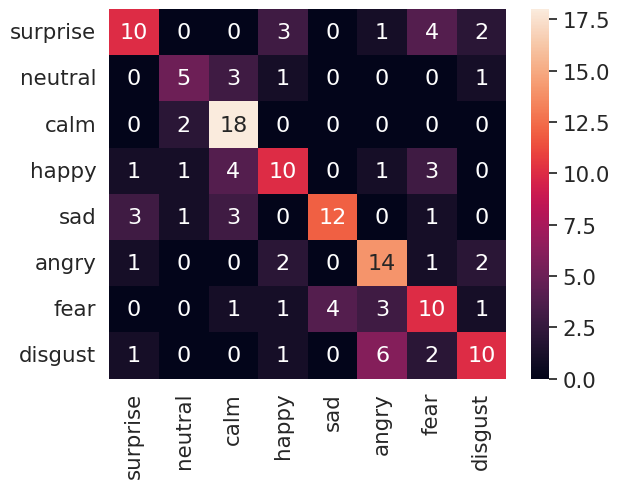

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between emotion intensity and corectness

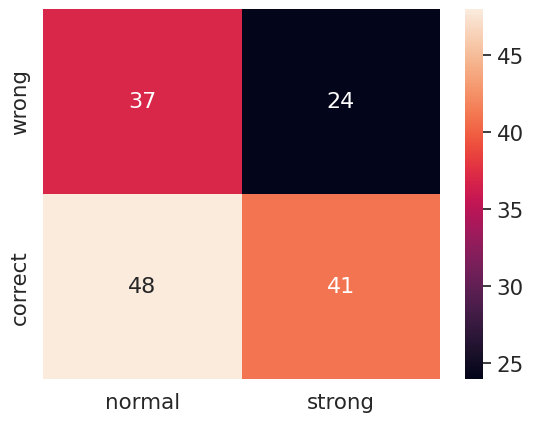

In [ ]:
correct_strong = 0
correct_normal = 0
wrong_strong = 0
wrong_normal = 0
for i in range(len(X_test)):
    intensity = data.loc[test_ind[i],'Emotion intensity']
    if Y_test[i] == predictions[i]: # correct prediction
        if  intensity == 'normal':
            correct_normal += 1
        else:
            correct_strong += 1
    else: # wrong prediction
        if intensity == 'normal':
            wrong_normal += 1
        else:
            wrong_strong += 1
array = np.array([[wrong_normal,wrong_strong],[correct_normal,correct_strong]])
df = pd.DataFrame(array,['wrong','correct'],['normal','strong'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

correlation between gender and corectness

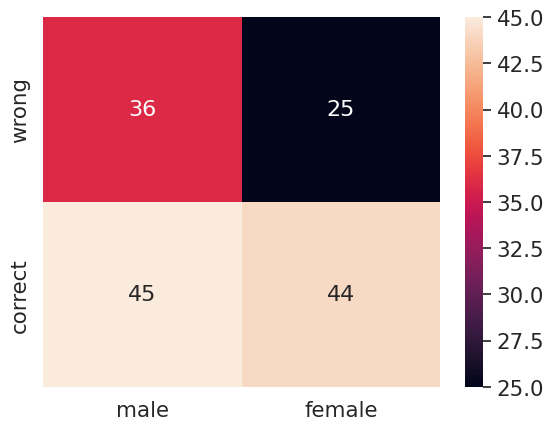

In [ ]:
correct_male = 0
correct_female = 0
wrong_male = 0
wrong_female = 0
for i in range(len(X_test)):
    gender = data.loc[test_ind[i],'Gender']
    if Y_test[i] == predictions[i]: # correct prediction
        if  gender == 'male':
            correct_male += 1
        else:
            correct_female += 1
    else: # wrong prediction
        if gender == 'male':
            wrong_male += 1
        else:
            wrong_female += 1
array = np.array([[wrong_male,wrong_female],[correct_male,correct_female]])
df = pd.DataFrame(array,['wrong','correct'],['male','female'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

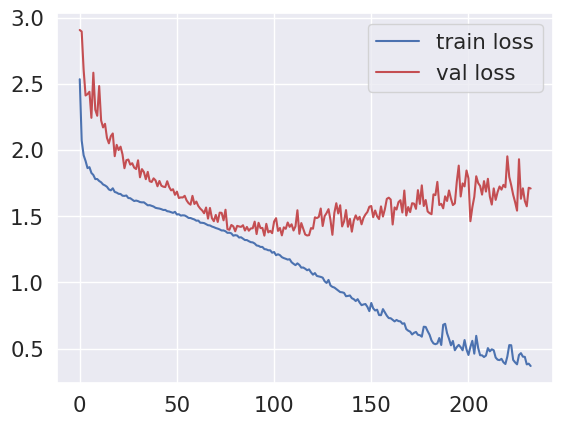

In [ ]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])